In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [4]:
#change the tickers here according to what's in the portfolio
tickers = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [5]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HSON    1259 non-null   float64
 1   ISSC    1259 non-null   float64
 2   KRNT    1259 non-null   float64
 3   RCII    1259 non-null   float64
 4   SAIA    1259 non-null   float64
 5   AMD     1259 non-null   float64
 6   EPAM    1259 non-null   float64
 7   ASML    1259 non-null   float64
 8   AUDC    1259 non-null   float64
 9   DSGX    1259 non-null   float64
 10  MGIC    1259 non-null   float64
 11  DHI     1259 non-null   float64
 12  LULU    1259 non-null   float64
 13  MBUU    1259 non-null   float64
 14  MCRI    1259 non-null   float64
 15  RUSHA   1259 non-null   float64
 16  CTLT    1259 non-null   float64
 17  IDXX    1259 non-null   float64
 18  BDSI    1259 non-null   float64
 19  MEDP    1259 non-null   float64
 20  MODV    1259 non-null   float64
 21  RGEN    1259 non-nu

## Function that saves dataframe to CSV

In [6]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [7]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [8]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [9]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [10]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [11]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [12]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [13]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [14]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [15]:
#change to the list of stocks we using
port_list = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

#add in the weightage of stocks
port_shares = [0.008618,0.003478667,0.01438,0.008773333,0.031416667,
              0.007651333,0.016572667,0.017943333,0.010706,0.009872667,
              0.003921333,0.012,0.037236667,0.00684,0.001423333,0.009167333,
              0.000710667,0.024792,0.004878,0.006279333,0.006434,0.023572667,
              0.019544,0.027532,0.019590667,0.018427333,0.048239333,0.066666667,
              0.066666667,0.005342,0.061324667,0.4]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.122376,0.010410,0.190535,0.093547,1.410608,0.087455,1.055016,1.891709,0.065778,0.209794,...,0.157901,0.244118,2.506658,6.940155,2.933547,0.019659,0.521260,0.7776,28.195413,NaN
2017-01-04,0.126685,0.010500,0.185502,0.094512,1.415321,0.087455,1.066617,1.882632,0.064979,0.211769,...,0.148889,0.262719,2.575622,6.950020,2.960790,0.020994,0.520646,0.7788,28.455547,0.009226
2017-01-05,0.125823,0.010829,0.179750,0.090092,1.380763,0.086001,1.073080,1.905240,0.062783,0.208807,...,0.140661,0.258999,2.560903,6.857949,2.952095,0.020834,0.524326,0.7452,28.252918,-0.007121
2017-01-06,0.124099,0.010769,0.181907,0.086395,1.409980,0.086613,1.108214,1.903185,0.063981,0.209794,...,0.140465,0.263959,2.535253,6.807968,2.941082,0.020567,0.517580,0.7688,28.278094,0.000891
2017-01-09,0.120652,0.011218,0.191973,0.086877,1.385475,0.087914,1.107717,1.926649,0.062983,0.209301,...,0.139094,0.260062,2.507919,6.773113,2.878481,0.021154,0.522486,0.7524,28.090193,-0.006645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.240011,0.022298,2.205317,0.431648,10.463321,1.181060,11.551149,14.559759,0.373104,0.807782,...,0.497407,0.772478,5.602629,25.557332,4.842802,0.099361,6.006751,0.5008,133.560115,0.022491
2021-12-28,0.242855,0.022959,2.192231,0.429279,10.373469,1.171802,11.305874,14.440256,0.370535,0.809559,...,0.490746,0.772478,5.496964,25.648668,4.836849,0.097011,5.927029,0.4980,132.454036,-0.008282
2021-12-29,0.241821,0.022750,2.219984,0.433052,10.537464,1.134387,11.233617,14.390194,0.372676,0.813903,...,0.499758,0.772294,5.518097,25.663334,4.823619,0.096744,5.927029,0.5176,132.767729,0.002368


## Get old data for portfolio

In [16]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.122376,0.010410,0.190535,0.093547,1.410608,0.087455,1.055016,1.891709,0.065778,0.209794,...,0.157901,0.244118,2.506658,6.940155,2.933547,0.019659,0.521260,0.7776,28.195413,NaN
2017-01-04,0.126685,0.010500,0.185502,0.094512,1.415321,0.087455,1.066617,1.882632,0.064979,0.211769,...,0.148889,0.262719,2.575622,6.950020,2.960790,0.020994,0.520646,0.7788,28.455547,0.009226
2017-01-05,0.125823,0.010829,0.179750,0.090092,1.380763,0.086001,1.073080,1.905240,0.062783,0.208807,...,0.140661,0.258999,2.560903,6.857949,2.952095,0.020834,0.524326,0.7452,28.252918,-0.007121
2017-01-06,0.124099,0.010769,0.181907,0.086395,1.409980,0.086613,1.108214,1.903185,0.063981,0.209794,...,0.140465,0.263959,2.535253,6.807968,2.941082,0.020567,0.517580,0.7688,28.278094,0.000891
2017-01-09,0.120652,0.011218,0.191973,0.086877,1.385475,0.087914,1.107717,1.926649,0.062983,0.209301,...,0.139094,0.260062,2.507919,6.773113,2.878481,0.021154,0.522486,0.7524,28.090193,-0.006645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.240011,0.022298,2.205317,0.431648,10.463321,1.181060,11.551149,14.559759,0.373104,0.807782,...,0.497407,0.772478,5.602629,25.557332,4.842802,0.099361,6.006751,0.5008,133.560115,0.022491
2021-12-28,0.242855,0.022959,2.192231,0.429279,10.373469,1.171802,11.305874,14.440256,0.370535,0.809559,...,0.490746,0.772478,5.496964,25.648668,4.836849,0.097011,5.927029,0.4980,132.454036,-0.008282
2021-12-29,0.241821,0.022750,2.219984,0.433052,10.537464,1.134387,11.233617,14.390194,0.372676,0.813903,...,0.499758,0.772294,5.518097,25.663334,4.823619,0.096744,5.927029,0.5176,132.767729,0.002368


## Forecasting

In [17]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [18]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [19]:
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.122376,0.010410,0.190535,0.093547,1.410608,0.087455,1.055016,1.891709,0.065778,0.209794,...,0.157901,0.244118,2.506658,6.940155,2.933547,0.019659,0.521260,0.7776,28.195413,NaN
2017-01-04,0.126685,0.010500,0.185502,0.094512,1.415321,0.087455,1.066617,1.882632,0.064979,0.211769,...,0.148889,0.262719,2.575622,6.950020,2.960790,0.020994,0.520646,0.7788,28.455547,0.009226
2017-01-05,0.125823,0.010829,0.179750,0.090092,1.380763,0.086001,1.073080,1.905240,0.062783,0.208807,...,0.140661,0.258999,2.560903,6.857949,2.952095,0.020834,0.524326,0.7452,28.252918,-0.007121
2017-01-06,0.124099,0.010769,0.181907,0.086395,1.409980,0.086613,1.108214,1.903185,0.063981,0.209794,...,0.140465,0.263959,2.535253,6.807968,2.941082,0.020567,0.517580,0.7688,28.278094,0.000891
2017-01-07,0.124099,0.010769,0.181907,0.086395,1.409980,0.086613,1.108214,1.903185,0.063981,0.209794,...,0.140465,0.263959,2.535253,6.807968,2.941082,0.020567,0.517580,0.7688,28.278094,0.000891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.240011,0.022298,2.205317,0.431648,10.463321,1.181060,11.551149,14.559759,0.373104,0.807782,...,0.497407,0.772478,5.602629,25.557332,4.842802,0.099361,6.006751,0.5008,133.560115,0.022491
2021-12-28,0.242855,0.022959,2.192231,0.429279,10.373469,1.171802,11.305874,14.440256,0.370535,0.809559,...,0.490746,0.772478,5.496964,25.648668,4.836849,0.097011,5.927029,0.4980,132.454036,-0.008282
2021-12-29,0.241821,0.022750,2.219984,0.433052,10.537464,1.134387,11.233617,14.390194,0.372676,0.813903,...,0.499758,0.772294,5.518097,25.663334,4.823619,0.096744,5.927029,0.5176,132.767729,0.002368


In [20]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [21]:
tot_port_df

,Total
Date,
2017-01-03,28.195413
2017-01-04,28.455547
2017-01-05,28.252918
2017-01-06,28.278094
2017-01-07,28.278094
...,...
2021-12-27,133.560115
2021-12-28,132.454036
2021-12-29,132.767729


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


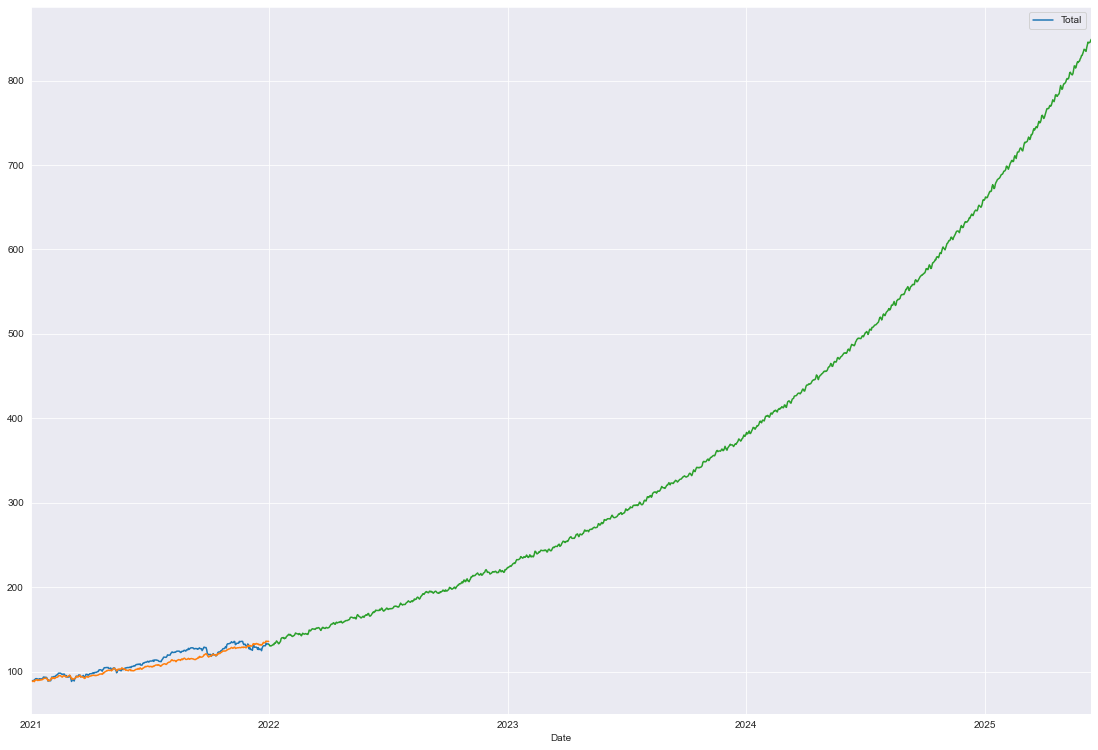

In [22]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [23]:
forecast

2021-12-31    132.291917
2022-01-01    131.567015
2022-01-02    130.287787
2022-01-03    130.513525
2022-01-04    130.488338
                 ...    
2025-06-09    844.739864
2025-06-10    844.833077
2025-06-11    845.178460
2025-06-12    847.220512
2025-06-13    848.867736
Freq: D, Length: 1261, dtype: float64

In [24]:
forecast_df = pd.DataFrame(forecast)

In [25]:
forecast_df

,0
2021-12-31,132.291917
2022-01-01,131.567015
2022-01-02,130.287787
2022-01-03,130.513525
2022-01-04,130.488338
...,...
2025-06-09,844.739864
2025-06-10,844.833077
2025-06-11,845.178460
2025-06-12,847.220512


In [26]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [27]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.005480
2022-01-02,-0.015149
2022-01-03,-0.013443
2022-01-04,-0.013633
...,...
2025-06-09,5.385423
2025-06-10,5.386128
2025-06-11,5.388738
2025-06-12,5.404174


In [28]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  45.031168
